# Set ENV Variable to Project Path

In [1]:
# Automatically reload modules when they change
%load_ext autoreload
%autoreload 2

Insert project root folder in environment variable

In [2]:
import os
import sys

def find_project_root(start_path=None, markers=(".git", "pyproject.toml", "requirements.txt")):
    """
    Walks up from start_path until it finds one of the marker files/folders.
    Returns the path of the project root.
    """
    if start_path is None:
        start_path = os.getcwd()

    current_path = os.path.abspath(start_path)

    while True:
        # check if any marker exists in current path
        if any(os.path.exists(os.path.join(current_path, marker)) for marker in markers):
            return current_path

        new_path = os.path.dirname(current_path)  # parent folder
        if new_path == current_path:  # reached root of filesystem
            raise FileNotFoundError(f"None of the markers {markers} found above {start_path}")
        current_path = new_path

project_root = find_project_root()
print("Project root:", project_root)

if project_root not in sys.path:
    sys.path.insert(0, project_root)


Project root: c:\ds_analytics_projects\darshil_course\apache-pyspark\darshil-pyspark


# Import Libraries

Import packages

In [3]:
import pandas as pd
import numpy as np

Relative import

In [4]:
from utils.file_utils import get_project_path

Import pyspark package and create a spark sesstion

In [5]:
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder \
    .appName("UDF Example") \
    .getOrCreate()


# 📒 Joins

### 🔎 Step 1: What is a Join?

- A **join** brings together two datasets (left & right) based on one or more **keys**.
- The join expression decides **which rows from left & right should be combined**.
- This is exactly like SQL joins or Excel lookups, but **distributed at scale**.

### 🔎 Step 2: Example DataFrames

We’ll use these three DataFrames for join examples:

In [6]:
# People
person = spark.createDataFrame([
  (0, "Bill Chambers", 0, [100]),
  (1, "Matei Zaharia", 1, [500, 250, 100]),
  (2, "Michael Armbrust", 1, [250, 100])
]).toDF("id", "name", "graduate_program", "spark_status")

# Graduate programs
graduateProgram = spark.createDataFrame([
  (0, "Masters", "School of Information", "UC Berkeley"),
  (2, "Masters", "EECS", "UC Berkeley"),
  (1, "Ph.D.", "EECS", "UC Berkeley")
]).toDF("id", "degree", "department", "school")

# Spark status
sparkStatus = spark.createDataFrame([
  (500, "Vice President"),
  (250, "PMC Member"),
  (100, "Contributor")
]).toDF("id", "status")


Define join expression:

In [7]:
joinExpression = person["graduate_program"] == graduateProgram["id"]

### 🔎 Step 3: Types of Joins in Spark

#### 1. Inner Join

Keeps rows where keys exist in **both datasets**.

In [8]:
person.join(graduateProgram, joinExpression, how="inner").show()

+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
| id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|  1|   Matei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|  2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+



#### 2. Outer Join

Keeps rows with keys in **either dataset**. Missing values are filled with `null`.

In [9]:
person.join(graduateProgram, joinExpression, how="outer").show()


+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|   0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|   1|   Matei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|   2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|NULL|            NULL|            NULL|           NULL|  2|Masters|                EECS|UC Berkeley|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+



#### 3. Left Outer Join

Keeps **all rows from the left DataFrame** and matches from the right (else `null`).

In [10]:
graduateProgram.join(person, joinExpression, how="left_outer").show()

+---+-------+--------------------+-----------+----+----------------+----------------+---------------+
| id| degree|          department|     school|  id|            name|graduate_program|   spark_status|
+---+-------+--------------------+-----------+----+----------------+----------------+---------------+
|  0|Masters|School of Informa...|UC Berkeley|   0|   Bill Chambers|               0|          [100]|
|  2|Masters|                EECS|UC Berkeley|NULL|            NULL|            NULL|           NULL|
|  1|  Ph.D.|                EECS|UC Berkeley|   2|Michael Armbrust|               1|     [250, 100]|
|  1|  Ph.D.|                EECS|UC Berkeley|   1|   Matei Zaharia|               1|[500, 250, 100]|
+---+-------+--------------------+-----------+----+----------------+----------------+---------------+



### 4. Right Outer Join

Keeps **all rows from the right DataFrame** and matches from the left (else `null`).

In [11]:
person.join(graduateProgram, joinExpression, how="right_outer").show()

+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|   0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|NULL|            NULL|            NULL|           NULL|  2|Masters|                EECS|UC Berkeley|
|   2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|   1|   Matei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+



#### 5. Left Semi Join

Keeps rows from the left DataFrame **only if the key exists in the right**.

Does not include columns from the right DataFrame.

In [12]:
graduateProgram.join(person, joinExpression, how="left_semi").show()

+---+-------+--------------------+-----------+
| id| degree|          department|     school|
+---+-------+--------------------+-----------+
|  0|Masters|School of Informa...|UC Berkeley|
|  1|  Ph.D.|                EECS|UC Berkeley|
+---+-------+--------------------+-----------+



#### 6. Left Anti Join

Keeps rows from the left DataFrame **only if the key does NOT exist in the right**.

In [13]:
graduateProgram.join(person, joinExpression, how="left_anti").show()


+---+-------+----------+-----------+
| id| degree|department|     school|
+---+-------+----------+-----------+
|  2|Masters|      EECS|UC Berkeley|
+---+-------+----------+-----------+



#### 7. Cross Join (Cartesian Product)

Every row in left matched with every row in right.

⚠️ Explodes data size (`n × m` rows).

**⚠️ You must explicitly request a cross join (crossJoin() or join with cross), because it’s dangerous.**

In [14]:
graduateProgram.crossJoin(person).show()

+---+-------+--------------------+-----------+---+----------------+----------------+---------------+
| id| degree|          department|     school| id|            name|graduate_program|   spark_status|
+---+-------+--------------------+-----------+---+----------------+----------------+---------------+
|  0|Masters|School of Informa...|UC Berkeley|  0|   Bill Chambers|               0|          [100]|
|  0|Masters|School of Informa...|UC Berkeley|  1|   Matei Zaharia|               1|[500, 250, 100]|
|  0|Masters|School of Informa...|UC Berkeley|  2|Michael Armbrust|               1|     [250, 100]|
|  2|Masters|                EECS|UC Berkeley|  0|   Bill Chambers|               0|          [100]|
|  2|Masters|                EECS|UC Berkeley|  1|   Matei Zaharia|               1|[500, 250, 100]|
|  2|Masters|                EECS|UC Berkeley|  2|Michael Armbrust|               1|     [250, 100]|
|  1|  Ph.D.|                EECS|UC Berkeley|  0|   Bill Chambers|               0|       

# 📒 How Spark Performs Joins

When Spark executes a join, it must make sure that **rows with the same join key end up on the same executor**, otherwise they can’t be matched.

To achieve this, Spark uses two main strategies:

## 🔹 1. Shuffle Join (Big Table ↔ Big Table)

📌 **When used:** Both datasets are large.

- Spark partitions both tables by the join key.
- Each executor must exchange data with **all other executors** to ensure matching keys end up together.
- This leads to **all-to-all communication** (expensive network shuffle).

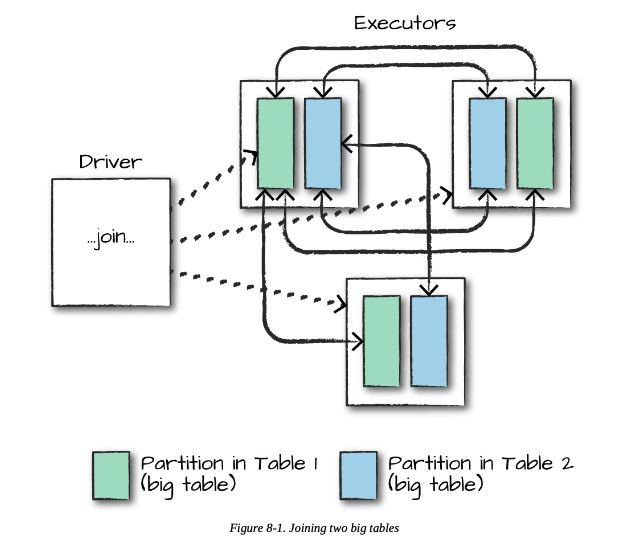

- Green = partitions from Table 1 (big table).
- Blue = partitions from Table 2 (big table).
- Notice how each executor **sends and receives data from every other executor**.

⚠️ Problem: Network congestion → slow jobs.

✅ Optimization: Good partitioning and fewer skewed keys reduce shuffle cost.

## 🔹 2. Broadcast Join (Big Table ↔ Small Table)

📌 **When used:** One dataset is small enough to fit into memory.

- Instead of shuffling both tables, Spark **copies the small table to every executor**.
- Each executor keeps a full copy of the small table and joins it locally with its partition of the big table.
- Communication happens **once at the beginning** (driver → executors), then no more network traffic.

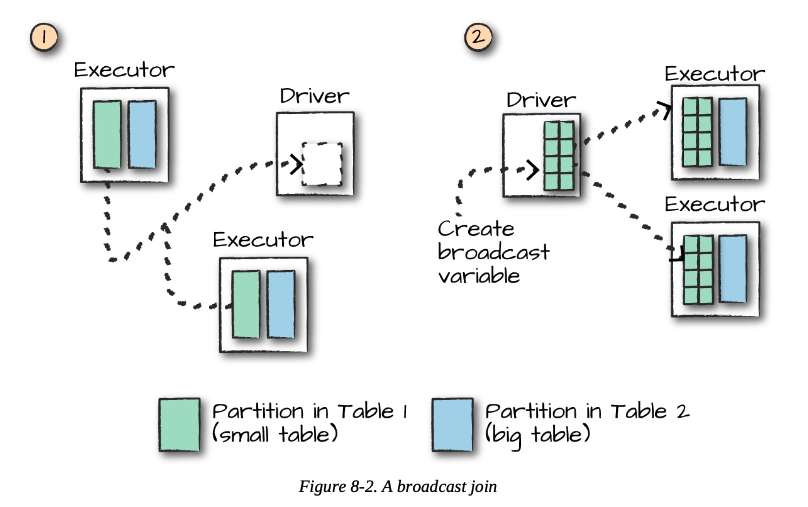

- Step 1: Small table collected at driver.
- Step 2: Small table broadcasted to every executor.
- Now, every executor can independently compute the join with its big table partition.

⚡ Much faster than shuffle joins because there’s no all-to-all data transfer.

✅ You can hint Spark to use broadcast joins:

In [15]:
from pyspark.sql.functions import broadcast

joinExpr = person["graduate_program"] == graduateProgram["id"]
person.join(broadcast(graduateProgram), joinExpr).explain()


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- BroadcastHashJoin [graduate_program#10L], [id#24L], Inner, BuildRight, false
   :- Project [_1#0L AS id#8L, _2#1 AS name#9, _3#2L AS graduate_program#10L, _4#3 AS spark_status#11]
   :  +- Filter isnotnull(_3#2L)
   :     +- Scan ExistingRDD[_1#0L,_2#1,_3#2L,_4#3]
   +- BroadcastExchange HashedRelationBroadcastMode(List(input[0, bigint, true]),false), [plan_id=791]
      +- Project [_1#16L AS id#24L, _2#17 AS degree#25, _3#18 AS department#26, _4#19 AS school#27]
         +- Filter isnotnull(_1#16L)
            +- Scan ExistingRDD[_1#16L,_2#17,_3#18,_4#19]




## 🔹 3. Small Table ↔ Small Table

📌 **When used:** Both datasets are small.

- Either strategy works.
- Spark usually picks a **broadcast join** automatically.
- You don’t need to interfere unless you see performance issues.

## 🔎 Why this matters?

- **Shuffle joins** (big-big) are costly because of **all-to-all communication**.
- **Broadcast joins** (big-small) are much faster when one table fits in memory.
- Understanding join strategy helps you **optimize performance** and avoid jobs that never finish.

---

✅ **In simple words**:

If both tables are big → Spark shuffles data everywhere (slow).

If one table is small → Spark copies it to every executor and avoids shuffling (fast).

If both are small → Spark decides, usually broadcast.

# 📒 Spark Join Strategies — Summary Table

| **Join Strategy** | **When to Use** | **How It Works** | **Pros** | **Cons** |
| --- | --- | --- | --- | --- |
| **Shuffle Join** (big ↔ big) | Both tables are large (don’t fit in memory) | Spark **shuffles** both tables across executors so matching keys end up together | Works with any dataset size | Very expensive (all-to-all communication, risk of data skew) |
| **Broadcast Join** (big ↔ small) | One table is **small enough to fit in memory** | Spark **copies the small table** to every executor and joins locally with big table partitions | Much faster (no shuffle after broadcast) | Small table must fit in executor memory; initial broadcast cost |
| **Broadcast Join** (small ↔ small) | Both tables are small | Spark can broadcast one table to all executors | Very efficient, avoids shuffle | None, unless both still too big for memory |
| **Cross Join (Cartesian)** | Special cases (e.g., generating all combinations) | Every row in left joined with every row in right | Sometimes needed for ML/feature engineering | Dangerous! Row count = N × M (explodes quickly) |

---

### ✅ Quick Rules of Thumb

- **Big ↔ Big → Shuffle Join** (be careful, optimize partitions).
- **Big ↔ Small → Broadcast Join** (preferred).
- **Small ↔ Small → Broadcast Join** (let Spark decide).
- **Cross Join → Avoid unless absolutely necessary**.

# 📒 Shuffle Join vs Broadcast Join — Code Example

### 🔎 Step 1: Setup Example DataFrames

In [16]:
# Big table (simulated with range)
bigDF = spark.range(0, 1_000_000).withColumnRenamed("id", "big_id")

# Small table (only a few rows)
smallDF = spark.createDataFrame([
    (1, "A"),
    (2, "B"),
    (3, "C")
], ["small_id", "value"])

### 🔎 Step 2: Shuffle Join (default)

When joining two tables **without broadcast**, Spark uses a **shuffle join** if one isn’t explicitly marked small.

⚠️ Notice Exchange `hashpartitioning` → indicates `shuffle` happening.

In [18]:
joinExpr = bigDF["big_id"] == smallDF["small_id"]

# Shuffle join
bigDF.join(smallDF.hint("shuffle_hash"), joinExpr).explain()


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- ShuffledHashJoin [big_id#345L], [small_id#347L], Inner, BuildRight
   :- Exchange hashpartitioning(big_id#345L, 200), ENSURE_REQUIREMENTS, [plan_id=837]
   :  +- Project [id#343L AS big_id#345L]
   :     +- Range (0, 1000000, step=1, splits=12)
   +- Exchange hashpartitioning(small_id#347L, 200), ENSURE_REQUIREMENTS, [plan_id=836]
      +- Filter isnotnull(small_id#347L)
         +- Scan ExistingRDD[small_id#347L,value#348]




### 🔎 Step 3: Broadcast Join

Force Spark to treat the small table as a **broadcast variable**.

⚡ Notice `BroadcastHashJoin` and `BroadcastExchange` → Spark is broadcasting `smallDF` instead of `shuffling` everything.

In [19]:
from pyspark.sql.functions import broadcast

bigDF.join(broadcast(smallDF), joinExpr).explain()


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- BroadcastHashJoin [big_id#345L], [small_id#347L], Inner, BuildRight, false
   :- Project [id#343L AS big_id#345L]
   :  +- Range (0, 1000000, step=1, splits=12)
   +- BroadcastExchange HashedRelationBroadcastMode(List(input[0, bigint, false]),false), [plan_id=859]
      +- Filter isnotnull(small_id#347L)
         +- Scan ExistingRDD[small_id#347L,value#348]




### 🔎 Step 4: Why this matters?

- Shuffle Join → good when both sides are big, but costly.
- Broadcast Join → best when one side is small → avoids shuffling big data around.
- `.explain()` helps you **debug Spark’s plan** and ensure it picked the optimal join strategy.

---

✅ **In simple words**:

Without broadcast, Spark shuffles both tables across the cluster. With broadcast, Spark ships the small table once and avoids the shuffle. `.explain()` shows you which strategy Spark chose.